 I) Préparation de l'environnement de travail
    
 II) Analyse du CA

 III) Tests statistiques
    
 IV) Conclusion

# Préparation de l'environnement de travail

In [1]:
#  Importation des librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import plotly.graph_objects as gp #pour la pyramide interactive
from pathlib import Path
from collections import defaultdict
from bs4 import BeautifulSoup as bs
from IPython.core.display import HTML
from scipy import stats
import scipy.stats as st
from pingouin import corr
from scipy.stats import pearsonr
from scipy.stats import spearmanr
# La ligne ci-dessous permet d'afficher les graphiques dans jupyterlab
from scipy import stats
%matplotlib inline
import matplotlib.patches as mpatches
from scipy.stats import bartlett


plt.rcParams['figure.figsize'] = (12,8)

In [2]:
# Importation des fichiers

customers = pd.read_csv('customers.csv')
customers.sample()

client_id sex  birth
2340    c_1062   m   1986

In [3]:
customers.shape

(8623, 3)

In [4]:
customers.dtypes

client_id    object
sex          object
birth         int64
dtype: object

In [5]:
products = pd.read_csv('products.csv')
products.sample()

id_prod  price  categ
1176   0_287   9.99      0

In [6]:
products.shape

(3287, 3)

In [7]:
products.dtypes

id_prod     object
price      float64
categ        int64
dtype: object

In [8]:
transactions = pd.read_csv('transactions.csv')
transactions.sample()

id_prod                        date session_id client_id
397920  0_1627  2022-10-17 22:33:56.017558   s_283992    c_1708

In [9]:
transactions.shape

(679532, 4)

In [10]:
transactions.dtypes

id_prod       object
date          object
session_id    object
client_id     object
dtype: object

Le nombre de lignes et de colonnes des DF corréspond à ceux issues des fichiers .CSV

# Nettoyage de données

## Valeur test

Les test ont été effectués sur nos DF. Pour la suite de notre analyse nous devons écarter ces valeurs test qui correspondent au id_prod = T_0.

### DF: products

In [11]:
# 1. valeurs négative dans DF products

In [12]:
products.loc[products['id_prod'] == 'T_0', :]

id_prod  price  categ
731     T_0   -1.0      0

In [13]:
products = products.loc[products['id_prod'] != 'T_0', :]
len(products)

3286

### DF: transactions

In [14]:
# 2. T_0 trouve correspondance avec le merge des deux DF. Il s'agit des tests à excure

In [15]:
transactions.loc[transactions['id_prod'] == 'T_0', :]

id_prod                             date session_id client_id
3019       T_0  test_2021-03-01 02:30:02.237419        s_0      ct_0
5138       T_0  test_2021-03-01 02:30:02.237425        s_0      ct_0
9668       T_0  test_2021-03-01 02:30:02.237437        s_0      ct_1
10728      T_0  test_2021-03-01 02:30:02.237436        s_0      ct_0
15292      T_0  test_2021-03-01 02:30:02.237430        s_0      ct_0
...        ...                              ...        ...       ...
657830     T_0  test_2021-03-01 02:30:02.237417        s_0      ct_0
662081     T_0  test_2021-03-01 02:30:02.237427        s_0      ct_1
670680     T_0  test_2021-03-01 02:30:02.237449        s_0      ct_1
671647     T_0  test_2021-03-01 02:30:02.237424        s_0      ct_1
679180     T_0  test_2021-03-01 02:30:02.237425        s_0      ct_1

[200 rows x 4 columns]

In [16]:
transactions = transactions.loc[transactions['id_prod'] != 'T_0', :]
len(transactions)

679332

## Valeurs manquantes

In [17]:
customers.isna().sum()

client_id    0
sex          0
birth        0
dtype: int64

In [18]:
products.isna().sum()

id_prod    0
price      0
categ      0
dtype: int64

In [19]:
transactions.isna().sum()

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

 Nous n'avons pas de valeurs manquantes dans nos DF

## Recherche de doublons

In [20]:
customers.loc[customers[['client_id']].duplicated(keep=False),:]

Empty DataFrame
Columns: [client_id, sex, birth]
Index: []

In [21]:
products.loc[products[['id_prod']].duplicated(keep=False),:]

Empty DataFrame
Columns: [id_prod, price, categ]
Index: []

In [22]:
transactions.loc[transactions[['id_prod', 'client_id','session_id','date']].duplicated(keep=False),:]

Empty DataFrame
Columns: [id_prod, date, session_id, client_id]
Index: []

## Erreur type

### DF : transactions

In [23]:
transactions.dtypes

id_prod       object
date          object
session_id    object
client_id     object
dtype: object

On doit changer le type de la variable date

In [24]:
transactions_c = transactions.copy()

In [25]:
transactions_c['date'] = transactions_c['date'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))

In [26]:
transactions_c.dtypes

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
dtype: object

In [27]:
transactions_c['date'] = pd.to_datetime(transactions_c['date'], format = '%d-%m-%Y')

In [28]:
transactions_c

id_prod                       date session_id client_id
0       0_1518 2022-05-20 13:21:29.043970   s_211425     c_103
1        1_251 2022-02-02 07:55:19.149409   s_158752    c_8534
2       0_1277 2022-06-18 15:44:33.155329   s_225667    c_6714
3        2_209 2021-06-24 04:19:29.835891    s_52962    c_6941
4       0_1509 2023-01-11 08:22:08.194479   s_325227    c_4232
...        ...                        ...        ...       ...
679527  0_1551 2022-01-15 13:05:06.246925   s_150195    c_8489
679528   1_639 2022-03-19 16:03:23.429229   s_181434    c_4370
679529  0_1425 2022-12-20 04:33:37.584749   s_314704     c_304
679530  0_1994 2021-07-16 20:36:35.350579    s_63204    c_2227
679531   1_523 2022-09-28 01:12:01.973763   s_274568    c_3873

[679332 rows x 4 columns]

### DF: customers

In [29]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


### DF: products

In [30]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3286 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3286 non-null   object 
 1   price    3286 non-null   float64
 2   categ    3286 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 102.7+ KB


L'ensemble de nos DF ont des types de données conformes à nos attentes

## Detection des outliers

In [31]:
products.describe()

price        categ
count  3286.000000  3286.000000
mean     21.863597     0.370359
std      29.849786     0.615446
min       0.620000     0.000000
25%       6.990000     0.000000
50%      13.075000     0.000000
75%      22.990000     1.000000
max     300.000000     2.000000

 Etant donnée que nous avons des catégories de produits différents, l'écart qui existe entre nos produits paraît coherent. Le montant le plus élevé étant égal à 300€ et le plus bas à 0.62€.

# Jointure des DF

## Jointure entre DF transactions et produit

In [32]:
merge_transactions_products = pd.merge(transactions_c, products, on = 'id_prod', how = 'outer',indicator=True)
merge_transactions_products

id_prod                       date session_id client_id   price  categ  \
0       0_1518 2022-05-20 13:21:29.043970   s_211425     c_103    4.18    0.0   
1       0_1518 2021-09-26 12:37:29.780414    s_95811    c_6197    4.18    0.0   
2       0_1518 2021-05-06 17:14:43.117440    s_30782     c_682    4.18    0.0   
3       0_1518 2022-03-16 18:57:10.420103   s_180057    c_5932    4.18    0.0   
4       0_1518 2022-11-12 18:58:10.574853   s_296584    c_7217    4.18    0.0   
...        ...                        ...        ...       ...     ...    ...   
679348  0_1624                        NaT        NaN       NaN   24.50    0.0   
679349    2_86                        NaT        NaN       NaN  132.36    2.0   
679350   0_299                        NaT        NaN       NaN   22.99    0.0   
679351   0_510                        NaT        NaN       NaN   23.66    0.0   
679352  0_2308                        NaT        NaN       NaN   20.28    0.0   

            _merge  
0             both  
1             both  
2             both  
3             both  
4             both  
...            ...  
679348  right_only  
679349  right_only  
679350  right_only  
679351  right_only  
679352  right_only  

[679353 rows x 7 columns]

In [33]:
merge_transactions_products._merge.value_counts()

both          679111
left_only        221
right_only        21
Name: _merge, dtype: int64

In [34]:
merge_transactions_products[merge_transactions_products._merge=='both'].head()

id_prod                       date session_id client_id  price  categ _merge
0  0_1518 2022-05-20 13:21:29.043970   s_211425     c_103   4.18    0.0   both
1  0_1518 2021-09-26 12:37:29.780414    s_95811    c_6197   4.18    0.0   both
2  0_1518 2021-05-06 17:14:43.117440    s_30782     c_682   4.18    0.0   both
3  0_1518 2022-03-16 18:57:10.420103   s_180057    c_5932   4.18    0.0   both
4  0_1518 2022-11-12 18:58:10.574853   s_296584    c_7217   4.18    0.0   both

In [35]:
merge_transactions_products[merge_transactions_products._merge=='both'].describe()

price          categ
count  679111.000000  679111.000000
mean       17.454773       0.441953
std        18.328998       0.595042
min         0.620000       0.000000
25%         8.870000       0.000000
50%        13.990000       0.000000
75%        18.990000       1.000000
max       300.000000       2.000000

In [36]:
merge_transactions_products[merge_transactions_products._merge=='left_only']

id_prod                       date session_id client_id  price  categ  \
542560  0_2245 2022-09-23 07:22:38.636773   s_272266    c_4746    NaN    NaN   
542561  0_2245 2022-07-23 09:24:14.133889   s_242482    c_6713    NaN    NaN   
542562  0_2245 2022-12-03 03:26:35.696673   s_306338    c_5108    NaN    NaN   
542563  0_2245 2021-08-16 11:33:25.481411    s_76493    c_1391    NaN    NaN   
542564  0_2245 2022-07-16 05:53:01.627491   s_239078    c_7954    NaN    NaN   
...        ...                        ...        ...       ...    ...    ...   
542776  0_2245 2021-08-25 09:06:03.504061    s_80395     c_131    NaN    NaN   
542777  0_2245 2022-03-06 19:59:19.462288   s_175311    c_4167    NaN    NaN   
542778  0_2245 2022-05-16 11:35:20.319501   s_209381    c_4453    NaN    NaN   
542779  0_2245 2022-02-11 09:05:43.952857   s_163405    c_1098    NaN    NaN   
542780  0_2245 2021-12-14 22:34:54.589921   s_134446    c_4854    NaN    NaN   

           _merge  
542560  left_only  
542561  left_only  
542562  left_only  
542563  left_only  
542564  left_only  
...           ...  
542776  left_only  
542777  left_only  
542778  left_only  
542779  left_only  
542780  left_only  

[221 rows x 7 columns]

In [37]:
merge_transactions_products[merge_transactions_products._merge=='left_only'].describe()

price  categ
count    0.0    0.0
mean     NaN    NaN
std      NaN    NaN
min      NaN    NaN
25%      NaN    NaN
50%      NaN    NaN
75%      NaN    NaN
max      NaN    NaN

Il s'agit ici d'un seul produit (id_prod = 0_2245) qui est absent dans le DF products et qui ne peut pas être comptabilisé. Etant donnée qu'il y a 221 commandes de ce produit il serait intéressant de retrouver son id_prod pour une prochaine analyse.

In [38]:
merge_transactions_products[merge_transactions_products._merge=='right_only'].head()

id_prod date session_id client_id  price  categ      _merge
679332  0_1016  NaT        NaN       NaN  35.06    0.0  right_only
679333  0_1780  NaT        NaN       NaN   1.67    0.0  right_only
679334  0_1062  NaT        NaN       NaN  20.08    0.0  right_only
679335  0_1119  NaT        NaN       NaN   2.99    0.0  right_only
679336  0_1014  NaT        NaN       NaN   1.15    0.0  right_only

In [39]:
merge_transactions_products[merge_transactions_products._merge=='right_only'].describe()

price      categ
count   21.000000  21.000000
mean    37.870476   0.380952
std     56.619963   0.740013
min      0.800000   0.000000
25%      2.990000   0.000000
50%     22.050000   0.000000
75%     31.820000   0.000000
max    220.990000   2.000000

Suite à la jointure externe on voit que la majorité des produits trouvent corréspondance dans le DF transactions. Cependant pour le calcul du CA nous ne pouvons pas utiliser ceux qui sont présents uniquement dans le DF 'products' (jointure à gauche uniquement) car il n'y a pas de prix dans ce cas. En ce qui concerne la jointure uniquement à droite (DF 'transactions'), nous pouvons utiliser ces données car les prix et les quantités sont prénsents.

In [40]:
df_filter = merge_transactions_products['_merge'].isin(['right_only','both'])
merge_transactions_products = merge_transactions_products[df_filter]

In [41]:
del merge_transactions_products['_merge']

## Jointure entre DF merge_transactions_producs et customers

In [42]:
customers

client_id sex  birth
0       c_4410   f   1967
1       c_7839   f   1975
2       c_1699   f   1984
3       c_5961   f   1962
4       c_5320   m   1943
...        ...  ..    ...
8618    c_7920   m   1956
8619    c_7403   f   1970
8620    c_5119   m   1974
8621    c_5643   f   1968
8622      c_84   f   1982

[8623 rows x 3 columns]

In [43]:
df_final = pd.merge(merge_transactions_products,customers, on = 'client_id', how = 'outer',indicator = True)
df_final

id_prod                       date session_id client_id  price  categ  \
0       0_1518 2022-05-20 13:21:29.043970   s_211425     c_103   4.18    0.0   
1       0_1518 2021-07-20 13:21:29.043970    s_64849     c_103   4.18    0.0   
2       0_1518 2022-08-20 13:21:29.043970   s_255965     c_103   4.18    0.0   
3       0_1418 2022-06-18 01:49:37.823274   s_225411     c_103   8.57    0.0   
4       0_1418 2021-08-18 01:49:37.823274    s_77214     c_103   8.57    0.0   
...        ...                        ...        ...       ...    ...    ...   
679150     NaN                        NaT        NaN    c_7584    NaN    NaN   
679151     NaN                        NaT        NaN      c_90    NaN    NaN   
679152     NaN                        NaT        NaN     c_587    NaN    NaN   
679153     NaN                        NaT        NaN      ct_1    NaN    NaN   
679154     NaN                        NaT        NaN    c_3526    NaN    NaN   

       sex   birth      _merge  
0        f  1986.0        both  
1        f  1986.0        both  
2        f  1986.0        both  
3        f  1986.0        both  
4        f  1986.0        both  
...     ..     ...         ...  
679150   f  1960.0  right_only  
679151   m  2001.0  right_only  
679152   m  1993.0  right_only  
679153   m  2001.0  right_only  
679154   m  1956.0  right_only  

[679155 rows x 9 columns]

In [44]:
df_final._merge.value_counts()

both          679111
right_only        23
left_only         21
Name: _merge, dtype: int64

In [45]:
df_final[df_final._merge=='both'].head()

id_prod                       date session_id client_id  price  categ sex  \
0  0_1518 2022-05-20 13:21:29.043970   s_211425     c_103   4.18    0.0   f   
1  0_1518 2021-07-20 13:21:29.043970    s_64849     c_103   4.18    0.0   f   
2  0_1518 2022-08-20 13:21:29.043970   s_255965     c_103   4.18    0.0   f   
3  0_1418 2022-06-18 01:49:37.823274   s_225411     c_103   8.57    0.0   f   
4  0_1418 2021-08-18 01:49:37.823274    s_77214     c_103   8.57    0.0   f   

    birth _merge  
0  1986.0   both  
1  1986.0   both  
2  1986.0   both  
3  1986.0   both  
4  1986.0   both

In [46]:
df_final[df_final._merge=='both'].describe()

price          categ          birth
count  679111.000000  679111.000000  679111.000000
mean       17.454773       0.441953    1977.811149
std        18.328998       0.595042      13.575361
min         0.620000       0.000000    1929.000000
25%         8.870000       0.000000    1970.000000
50%        13.990000       0.000000    1980.000000
75%        18.990000       1.000000    1987.000000
max       300.000000       2.000000    2004.000000

In [47]:
df_final[df_final._merge=='right_only'].head()

id_prod date session_id client_id  price  categ sex   birth      _merge
679132     NaN  NaT        NaN    c_8253    NaN    NaN   f  2001.0  right_only
679133     NaN  NaT        NaN    c_3789    NaN    NaN   f  1997.0  right_only
679134     NaN  NaT        NaN    c_4406    NaN    NaN   f  1998.0  right_only
679135     NaN  NaT        NaN      ct_0    NaN    NaN   f  2001.0  right_only
679136     NaN  NaT        NaN    c_2706    NaN    NaN   f  1967.0  right_only

In [48]:
df_final[df_final._merge=='right_only'].describe()

price  categ        birth
count    0.0    0.0    23.000000
mean     NaN    NaN  1985.826087
std      NaN    NaN    19.548662
min      NaN    NaN  1956.000000
25%      NaN    NaN  1964.000000
50%      NaN    NaN  1997.000000
75%      NaN    NaN  2001.000000
max      NaN    NaN  2004.000000

In [49]:
df_final[df_final._merge=='left_only'].head()

id_prod date session_id client_id  price  categ  sex  birth     _merge
679111  0_1016  NaT        NaN       NaN  35.06    0.0  NaN    NaN  left_only
679112  0_1780  NaT        NaN       NaN   1.67    0.0  NaN    NaN  left_only
679113  0_1062  NaT        NaN       NaN  20.08    0.0  NaN    NaN  left_only
679114  0_1119  NaT        NaN       NaN   2.99    0.0  NaN    NaN  left_only
679115  0_1014  NaT        NaN       NaN   1.15    0.0  NaN    NaN  left_only

In [50]:
df_final[df_final._merge=='left_only'].describe()

price      categ  birth
count   21.000000  21.000000    0.0
mean    37.870476   0.380952    NaN
std     56.619963   0.740013    NaN
min      0.800000   0.000000    NaN
25%      2.990000   0.000000    NaN
50%     22.050000   0.000000    NaN
75%     31.820000   0.000000    NaN
max    220.990000   2.000000    NaN

In [51]:
df_filter = df_final['_merge'].isin(['left_only','both'])
df_final = df_final[df_filter]

In [52]:
del df_final['_merge']

In [53]:
df_final.tail()

id_prod date session_id client_id   price  categ  sex  birth
679127  0_1624  NaT        NaN       NaN   24.50    0.0  NaN    NaN
679128    2_86  NaT        NaN       NaN  132.36    2.0  NaN    NaN
679129   0_299  NaT        NaN       NaN   22.99    0.0  NaN    NaN
679130   0_510  NaT        NaN       NaN   23.66    0.0  NaN    NaN
679131  0_2308  NaT        NaN       NaN   20.28    0.0  NaN    NaN

 En suivant la même logique, nous allons garder uniquement des individus ayant les prix c'est à dire la jointure 'both' et 'left_only'

On obtient donc ici notre DF final qui peut nous aider à caluler le CA réalisé durant toute la pédiode d'observation

In [54]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679132 entries, 0 to 679131
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679132 non-null  object        
 1   date        679111 non-null  datetime64[ns]
 2   session_id  679111 non-null  object        
 3   client_id   679111 non-null  object        
 4   price       679132 non-null  float64       
 5   categ       679132 non-null  float64       
 6   sex         679111 non-null  object        
 7   birth       679111 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 46.6+ MB


# Choix du DF final

## Calcul du CA avec des valeurs manquates

In [55]:
CA_1 = round(df_final['price'].sum(), 2)

In [56]:
print("Le total du chiffre d’affaires réalisé en ligne s'élève à : ",CA_1 , "€" )

Le total du chiffre d’affaires réalisé en ligne s'élève à :  11854523.96 €


In [57]:
print("Ce qui represente : ", round(df_final['price'].mean(), 2), "€ par transaction en moyenne.")

Ce qui represente :  17.46 € par transaction en moyenne.


## Calcul du CA sans valeurs manquantes

In [58]:
df_final_without_NaN = df_final.dropna(how="any")

In [59]:
CA_2 = round(df_final_without_NaN['price'].sum(), 2)

In [60]:
print("Le CA aprés la supprression des valeurs manquantes s'élève à : ", CA_2 , "€")

Le CA aprés la supprression des valeurs manquantes s'élève à :  11853728.68 €


## Choix du DF

In [61]:
diff_CA = round(CA_1 - CA_2,2)
ratio_diff_CA = round(diff_CA/CA_2,4)
with_nan = len(df_final)
without_nan = len(df_final_without_NaN)
len_diff = with_nan - without_nan
ratio_len_diff = round(100*len_diff/with_nan ,4)

Besoin du nettoyage des profils client

In [62]:
print("En enlevant les valeurs manquantes(des profils clients), c'est-à-dire celles qui ne trouvent pas les correspondances dans toutes les tables, on omet :", diff_CA, "€.")

print("Propotionellement cet écart reste donc négligeable car il ne respresente qu'environ : ", ratio_diff_CA, "% de notre CA." )

print("Le nombre de transactions que nous avons enlevé quand à lui s'élève à : ", len_diff, "donc environ : ", ratio_len_diff, '%')

En enlevant les valeurs manquantes(des profils clients), c'est-à-dire celles qui ne trouvent pas les correspondances dans toutes les tables, on omet : 795.28 €.
Propotionellement cet écart reste donc négligeable car il ne respresente qu'environ :  0.0001 % de notre CA.
Le nombre de transactions que nous avons enlevé quand à lui s'élève à :  21 donc environ :  0.0031 %


 Pour la suite de notre analyse nous allons donc nous appuyer sur le DF sans les valeurs manquantes.

In [63]:
df = df_final_without_NaN
df

id_prod                       date session_id client_id   price  categ  \
0       0_1518 2022-05-20 13:21:29.043970   s_211425     c_103    4.18    0.0   
1       0_1518 2021-07-20 13:21:29.043970    s_64849     c_103    4.18    0.0   
2       0_1518 2022-08-20 13:21:29.043970   s_255965     c_103    4.18    0.0   
3       0_1418 2022-06-18 01:49:37.823274   s_225411     c_103    8.57    0.0   
4       0_1418 2021-08-18 01:49:37.823274    s_77214     c_103    8.57    0.0   
...        ...                        ...        ...       ...     ...    ...   
679106   2_147 2021-07-23 07:01:38.963669    s_65994    c_4391  181.99    2.0   
679107   0_142 2022-03-25 18:07:25.880052   s_184472    c_1232   19.85    0.0   
679108   0_142 2021-09-25 18:07:25.880052    s_95415    c_1232   19.85    0.0   
679109   2_205 2021-03-11 00:11:32.016264     s_4605    c_7534  100.99    2.0   
679110   2_205 2022-07-11 00:11:32.016264   s_236636    c_7534  100.99    2.0   

       sex   birth  
0        f  1986.0  
1        f  1986.0  
2        f  1986.0  
3        f  1986.0  
4        f  1986.0  
...     ..     ...  
679106   f  2001.0  
679107   f  1960.0  
679108   f  1960.0  
679109   m  1992.0  
679110   m  1992.0  

[679111 rows x 8 columns]

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679111 entries, 0 to 679110
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679111 non-null  object        
 1   date        679111 non-null  datetime64[ns]
 2   session_id  679111 non-null  object        
 3   client_id   679111 non-null  object        
 4   price       679111 non-null  float64       
 5   categ       679111 non-null  float64       
 6   sex         679111 non-null  object        
 7   birth       679111 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 46.6+ MB


In [65]:
df['categ'] = df['categ'].astype(int)
df['birth'] = df['birth'].astype(int)

In [66]:
df

id_prod                       date session_id client_id   price  categ  \
0       0_1518 2022-05-20 13:21:29.043970   s_211425     c_103    4.18      0   
1       0_1518 2021-07-20 13:21:29.043970    s_64849     c_103    4.18      0   
2       0_1518 2022-08-20 13:21:29.043970   s_255965     c_103    4.18      0   
3       0_1418 2022-06-18 01:49:37.823274   s_225411     c_103    8.57      0   
4       0_1418 2021-08-18 01:49:37.823274    s_77214     c_103    8.57      0   
...        ...                        ...        ...       ...     ...    ...   
679106   2_147 2021-07-23 07:01:38.963669    s_65994    c_4391  181.99      2   
679107   0_142 2022-03-25 18:07:25.880052   s_184472    c_1232   19.85      0   
679108   0_142 2021-09-25 18:07:25.880052    s_95415    c_1232   19.85      0   
679109   2_205 2021-03-11 00:11:32.016264     s_4605    c_7534  100.99      2   
679110   2_205 2022-07-11 00:11:32.016264   s_236636    c_7534  100.99      2   

       sex  birth  
0        f   1986  
1        f   1986  
2        f   1986  
3        f   1986  
4        f   1986  
...     ..    ...  
679106   f   2001  
679107   f   1960  
679108   f   1960  
679109   m   1992  
679110   m   1992  

[679111 rows x 8 columns]

## Création de colonnes manquantes

In [67]:
# 1. Création de la variable: Année-mois
df['year_month'] = pd.to_datetime(df['date']).dt.to_period('m')

In [68]:
df.dtypes

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
price                float64
categ                  int32
sex                   object
birth                  int32
year_month         period[M]
dtype: object

In [69]:
print('Les transactions dans notre base de donnée débutent au : ', str(df['year_month'].min())[:10], 'et finissent au : ', str(df['year_month'].max())[:10])

Les transactions dans notre base de donnée débutent au :  2021-03 et finissent au :  2023-02


In [70]:
# 2. Création de la variable: âge

In [71]:
df["age"] = 2022 - df["birth"]

In [72]:
# 3. Création de la variable: classe d'âge

In [73]:
df['classe_age'] = '18-30'
df['classe_age'].loc[df[df['age']>=31].index] = '31-50'
df['classe_age'].loc[df[df['age']>=51].index] = '51 +'

## Le cas du mois d'octobre 2021

In [74]:
CA_global= pd.pivot_table(df,values='price',index="year_month", aggfunc='sum') 

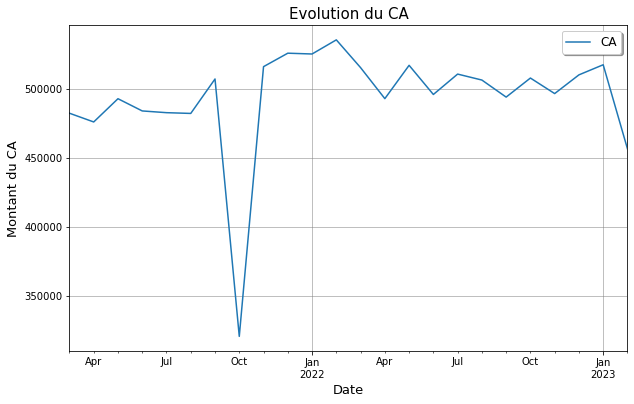

In [75]:
CA_global['price'].plot(figsize = (10,6), label = 'CA')

plt.title('Evolution du CA',fontsize=15)
plt.xlabel('Date',fontsize=13)
plt.ylabel('Montant du CA',fontsize=13)

plt.legend(loc="best",                                
          shadow = True,                              
          fontsize = 'large')                         
          
plt.grid(color='gray', linestyle='-', linewidth=0.5)

plt.style.use('fivethirtyeight')            

plt.show()

En regardant plus en détails les chiffres de notre DF, on observe une importante baisse du CA sans raisons apparrentes au mois d'octobre 2021. Nous pouvons voir plus en détails d'où provient cette baisse

In [76]:
df_oct21 = df[df['year_month']=='2021-10']

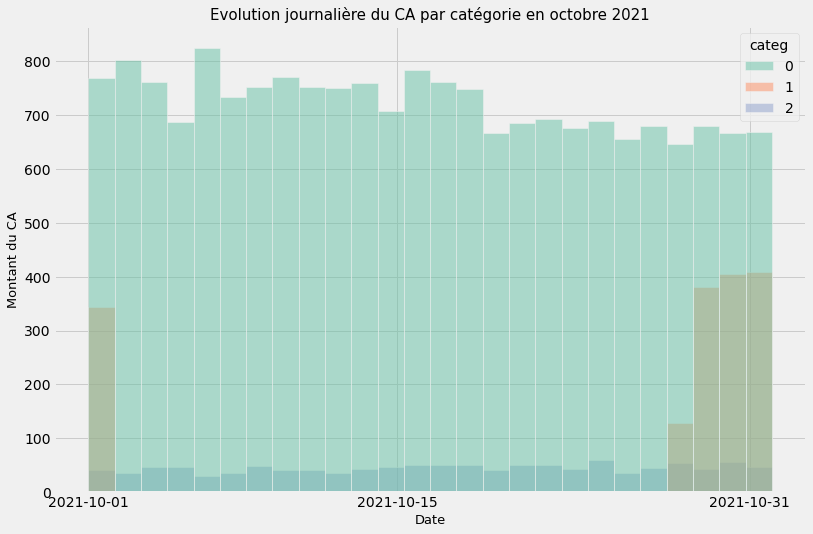

In [77]:
sns.histplot(data=df_oct21,
             x='date',
             hue='categ',
             palette="Set2")

plt.xticks(['2021-10-01','2021-10-15','2021-10-31'])
plt.title('Evolution journalière du CA par catégorie en octobre 2021',fontsize=15)
plt.xlabel('Date',fontsize=13)
plt.ylabel('Montant du CA',fontsize=13)

plt.show();

 On voit ici qu'il n'y a plus de ventes de catégorie 1 entre le 02 et 27 octobre 2021 inclus.

In [78]:
df_clean = df.loc[~(df['year_month'] == '2021-10'), :]
len(df_clean)

657512

 Pour le reste de notre analyse, nous allons utiliser le DF: 'df_clean' qui exclu le mois d'octobre 2021

# Indicateurs de ventes (Antoine)

## Les indicateurs du CA global

### Evolution du CA avec sa moyenne mobile

In [79]:
#On utilise la fonction d'aggrégation sur la variable 'price' avec comme index 'year_mounth'

CA_globala_clean= pd.pivot_table(df_clean,values='price',index="year_month", aggfunc='sum')
CA_globala_clean.sample()

price
year_month           
2022-07     510783.12

In [80]:
# On crée les deux moyennes mobiles, une sur 3 périodes (=3 mois)

CA_globala_clean['MA 3'] = CA_globala_clean['price'].rolling(3).mean()
CA_globala_clean.head()

price           MA 3
year_month                          
2021-03     482440.61            NaN
2021-04     476109.30            NaN
2021-05     492943.47  483831.126667
2021-06     484088.56  484380.443333
2021-07     482835.40  486622.476667

In [81]:
CA_globala_clean.sample()

price           MA 3
year_month                          
2022-01     525338.99  522474.666667

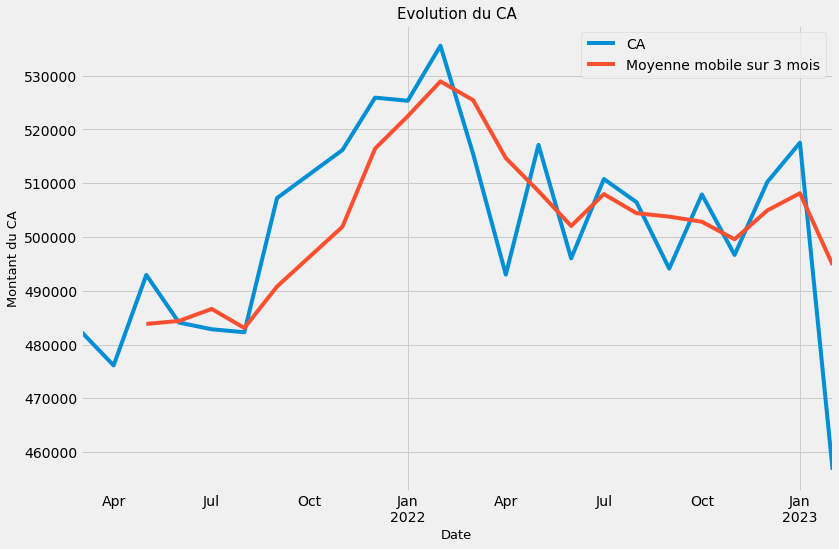

In [82]:
# Représentation de la moyenne mobile et de l'évolution du CA par mois

CA_globala_clean['price'].plot(label = 'CA')
CA_globala_clean['MA 3'].plot(label = 'Moyenne mobile sur 3 mois')


plt.title('Evolution du CA',fontsize=15)
plt.xlabel('Date',fontsize=13)
plt.ylabel('Montant du CA',fontsize=13)
plt.legend();

 La moyenne mobile sur 3 mois permets de voir l'évolution du CA en réduisant les fluctuations transitoires d'un mois sur l'autre. Grâce à la moyenne mobile nous pouvons voir les tendances de l'évolution du CA. Lorsqu'elle est en dessous de la courbe du CA la tendance est haussière (sur 3 mois), puis lorsqu'elle passe au-dessus la tendance s'inverse et devient baissière.
 
  Notre site connaît une hausse importante du CA d'août 2021 au février 2022, puis la tendance s'inverse globalement et on enregistre un ralentissement du CA.

## Zoom sur le profil client

### Courbe de Lorenz: répartition du CA

In [83]:
# Elle nous permet de voir la répartition du CA entre tous nos clients

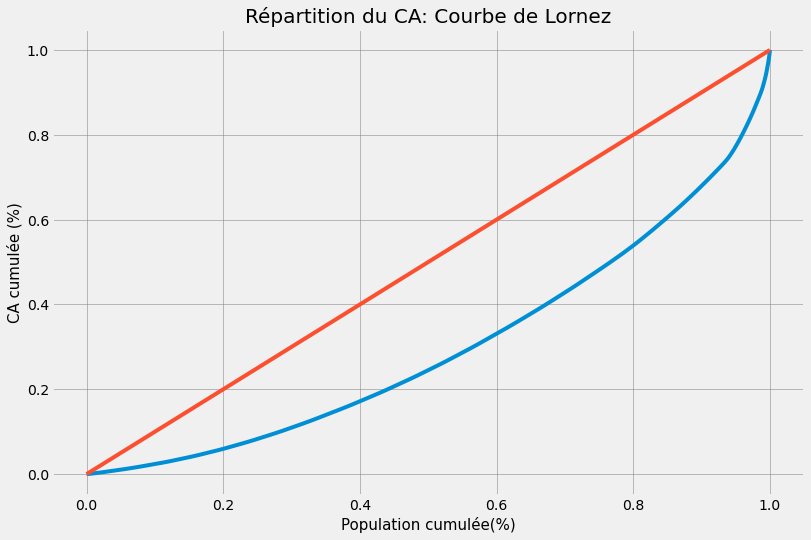

In [84]:
dep = df_clean['price'].values
n = len(dep)
lorenz = np.cumsum(np.sort(dep)) / dep.sum() #.cumsum petmet de calculer la somme cumulée
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
plt.title("Répartition du CA: Courbe de Lornez",fontsize=20)
plt.xlabel("Population cumulée(%)",fontsize=15)                                  
plt.ylabel("CA cumulée (%)",fontsize=15)
plt.grid(color='gray', linestyle='-', linewidth=0.5)
xaxis = np.linspace(0-1/n,1+1/n,len(lorenz)) 
plt.plot(xaxis,lorenz,drawstyle='steps-post')
plt.plot([0,1], [0,1]) #tracer la bisséctrice
plt.show()

In [85]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n
S = 0.5 - AUC
gini = 2*S
gini

0.3944443797025

 Nous pouvons donc conclure que le CA généré par nos clients est relativement bien repartie entre nos gros clients et les plus petits. Cependant on observe une accentuation de la pente pour les 10% des plus gros clients.

### Nb vente/client : B2B vs B2C

In [86]:
# Nombre d'achat par client unique
df_taille_client = pd.pivot_table(df_clean,values='price',index="client_id", aggfunc='count')
df_taille_client.sort_values('price')

price
client_id       
c_6879         1
c_6292         1
c_240          1
c_4436         1
c_1624         1
...          ...
c_3263       392
c_4958      5090
c_3454      6632
c_6714      8897
c_1609     24472

[8598 rows x 1 columns]

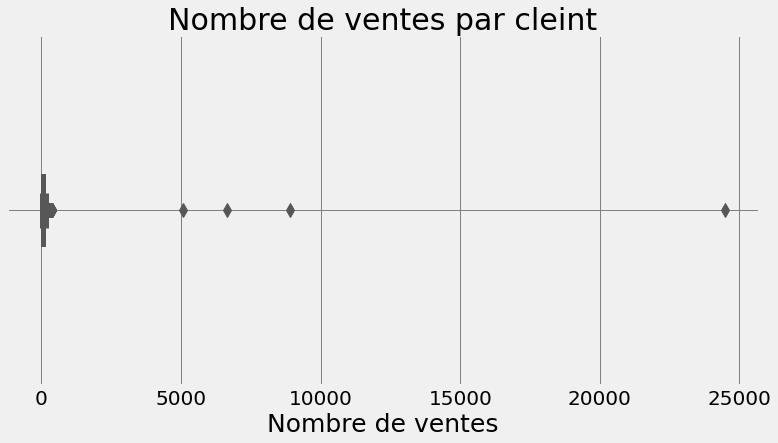

In [87]:
blue = sns.color_palette('cool_r')[5:]
fig_big = plt.figure(figsize=(12, 6))
sns.boxplot(df_taille_client.price,width=0.2,palette=blue,fliersize=10,linewidth=3)
plt.title("Nombre de ventes par cleint", fontsize=30)
plt.xlabel("Nombre de ventes",fontsize=25)
plt.xticks(fontsize=20)
plt.grid(color='gray', linestyle='-', linewidth=1)

In [88]:
BTC = df_clean.copy()
BTC = BTC.loc[~(BTC['client_id'] == 'c_4958')&~(BTC['client_id'] == 'c_3454')&~(BTC['client_id'] == 'c_6714')&~(BTC['client_id'] == 'c_1609'), :]

In [89]:
print(" En enlevant les 4 plus gros clients, on conserve : ",round(len(BTC)/len(df_clean)*100,2) , "% de nos données.")

 En enlevant les 4 plus gros clients, on conserve :  93.14 % de nos données.


In [90]:
# Nombre d'achat par client unique sans les 4 gros clients
df_taille_client_btc = pd.pivot_table(BTC,values='price',index="client_id", aggfunc='count')

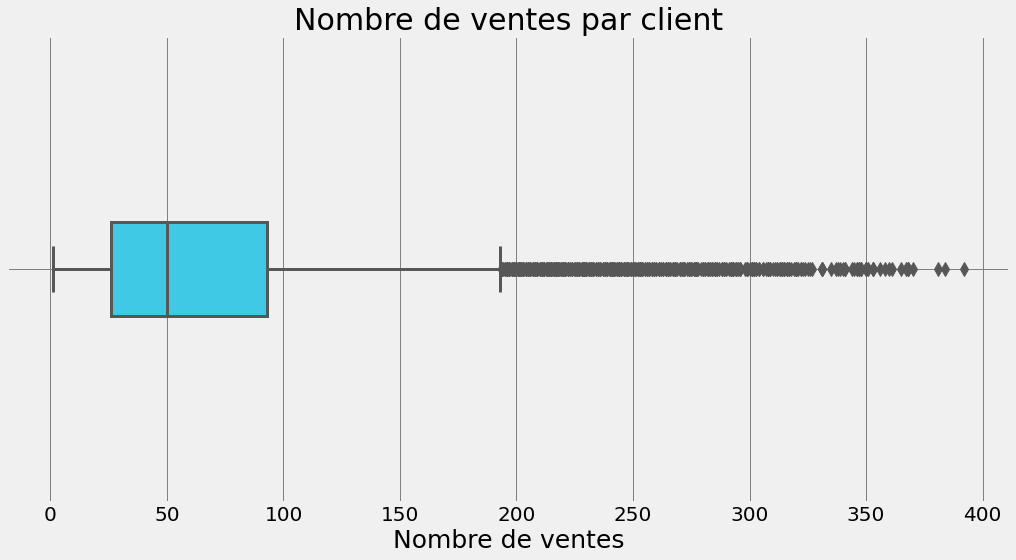

In [91]:
blue = sns.color_palette('cool_r')[5:]
fig = plt.figure(figsize=(16, 8))
sns.boxplot(df_taille_client_btc.price,width=0.2,palette=blue,fliersize=10,linewidth=3)
plt.title("Nombre de ventes par client", fontsize=30)
plt.xlabel("Nombre de ventes",fontsize=25)
plt.xticks(fontsize=20)
plt.grid(color='gray', linestyle='-', linewidth=1)

ZOOM sur le profil client via la méthode intérquartile

In [92]:
prix_iq = sorted(df_taille_client_btc['price'])
Q1 = np.percentile(prix_iq, 25)
Q3 = np.percentile(prix_iq, 75)
iQR = Q3 - Q1

bas = Q1 - 1.5*iQR
haut = Q3 + 1.5*iQR

outlier = df_taille_client_btc[(df_taille_client_btc['price'] > haut) | (df_taille_client_btc['price'] < bas)]

print('On obtient les paramètres suivants : ')
print('Q1 = ', Q1)
print('Q3 = ', Q3)
print('Ecart interquartile = ', iQR)
print("Le nombre d'outliers qui dépassent de 1.5 fois en dessous de Q1 et au-dessus de Q3 s'élève à : ", len(outlier))

On obtient les paramètres suivants : 
Q1 =  26.0
Q3 =  93.0
Ecart interquartile =  67.0
Le nombre d'outliers qui dépassent de 1.5 fois en dessous de Q1 et au-dessus de Q3 s'élève à :  590


 Ici nous avons 4 gros clients qui se démarquent très fortement des autres, il serrait plus judicieux d'écarter ces gros clients lorsqu'on analyse les comportements des clients particuliers. Cela revient à enlever environ 7% de nos transactions, afin d'avoir un échantillon plus fidèle et représentatif (CA/sex, CA/age...).

  Nous avons dans ce cas un échantillon plus homogène. Certains clients pro sont toujours présents dans notre DF, mais ils influencent de manière modéré notre analyse. Par conséquent nous pouvons les garder.

### Nombre de client par genre et par âge

In [93]:
# Recherche de doublons clients

df_client_unique = BTC.loc[BTC[['client_id']].duplicated(keep=False),:]

In [94]:
#Supréssions de doublons

df_client_unique.drop_duplicates(subset=['client_id'], inplace=True, ignore_index=True)

In [95]:
#Découper le tableau afin d'obtenir la forme souhaitée (3 colonnes : tranche âge, homme, femme)

Pydamide_sex_age = pd.pivot_table(df_client_unique,values='price',index="age",columns = 'sex', aggfunc='count')
Pydamide_sex_age.reset_index(inplace = True)

In [96]:
y_age = Pydamide_sex_age['age']
x_M = Pydamide_sex_age['m']
x_F = Pydamide_sex_age['f'] * -1

In [97]:
fig = gp.Figure()
fig.add_trace(gp.Bar(y= y_age, x = x_M, name = 'Homme', orientation = 'h'))
fig.add_trace(gp.Bar(y = y_age, x = x_F,name = 'Femme', orientation = 'h'))
fig.update_layout(title_font_size = 22, barmode = 'relative',bargap = 0.0, bargroupgap = 0,
                 xaxis = dict(tickvals = [-60000000, -40000000, -20000000,0, 20000000, 40000000, 60000000],
ticktext = ['6M', '4M', '2M', '0', '2M', '4M', '6M'],
title = "Repartition de clients par âge et genre",title_font_size = 14))
fig.show()

## Discrétisation du CA

### CA par catégorie

#### La répartition du CA par catégorie

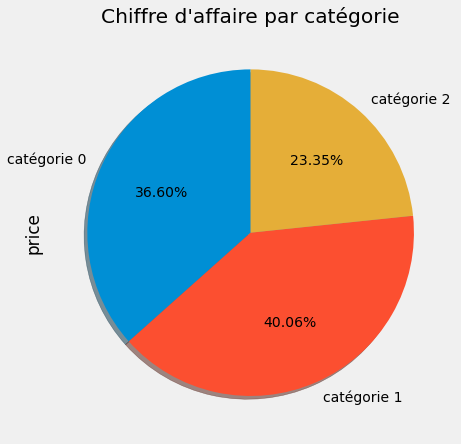

In [98]:
pd.pivot_table(data=df_clean,index='categ',values='price',
               aggfunc='sum').plot(kind='pie',labels = ['catégorie 0', 'catégorie 1', 'catégorie 2'], normalize = True,
                                   y='price',figsize=(10,7),legend=False,shadow=True,autopct='%1.2f%%',startangle =90)
plt.title("Chiffre d'affaire par catégorie");

#### Evolution du CA par catégorie

In [99]:
CA_categ_0= pd.pivot_table(df_clean.loc[df_clean['categ']==0],values='price',index="year_month", aggfunc='sum')
CA_categ_1= pd.pivot_table(df_clean.loc[df_clean['categ']==1],values='price',index="year_month", aggfunc='sum')
CA_categ_2= pd.pivot_table(df_clean.loc[df_clean['categ']==2],values='price',index="year_month", aggfunc='sum')

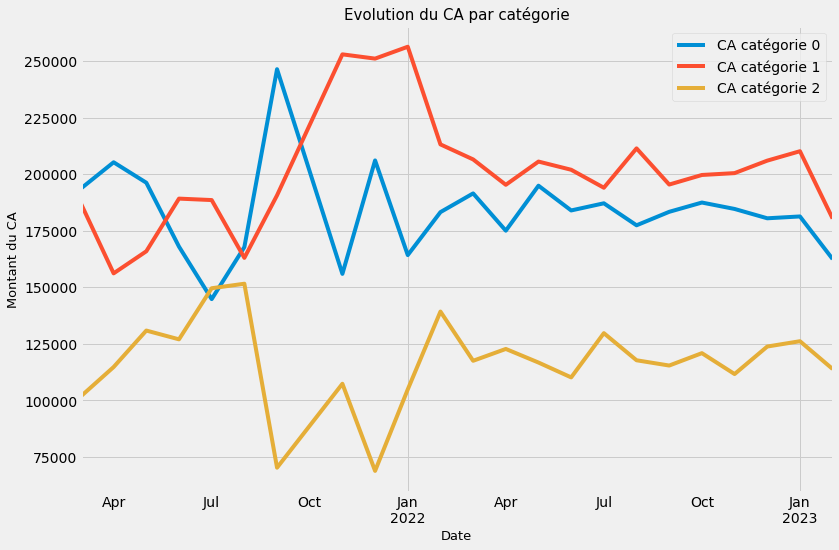

In [100]:
CA_categ_0['price'].plot(label = 'CA catégorie 0')
CA_categ_1['price'].plot(label = 'CA catégorie 1')
CA_categ_2['price'].plot(label = 'CA catégorie 2')

plt.title('Evolution du CA par catégorie',fontsize=15)
plt.xlabel('Date',fontsize=13)
plt.ylabel('Montant du CA',fontsize=13)
plt.legend();

1) Les ventes de l'année 2021 était les plus fluctuantes toute catégorie confondues. Elles correspondent au lancement de notre site intérnet.

2) Les variations des ventes entre nos différents produits lors de la première année peut être lié aux différents campagnes marketing que nous avons prtiqué sur cette période.

3) Les ventes sur toute l'année 2022 quand à elles sont beaucoup plus stables pour tous nos produits.

### CA par genre

#### La répartition du CA par genre

In [101]:
fem = round(BTC.loc[BTC['sex']=="f", 'price'].sum(),2)
mal = round(BTC.loc[BTC['sex']=="m", 'price'].sum(),2)

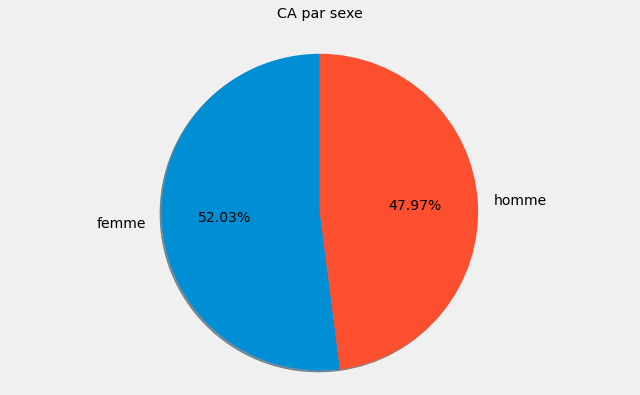

In [102]:
plt.figure(figsize=(10,6))
labels_q4 = ['femme','homme']
valeurs_q4 = [fem, mal]
plt.pie(x=valeurs_q4,labels = labels_q4,radius = 2,autopct='%.2f%%',explode = [0,0],shadow= True,startangle =90)
plt.style.use('ggplot')
plt.title("CA par sexe",
           pad = 20)
plt.axis('equal')
plt.show()

#### Evolution du CA par genre

In [103]:
CA_homme = pd.pivot_table(BTC.loc[BTC['sex']=='m'],values='price',index="year_month", aggfunc='sum')
CA_femme = pd.pivot_table(BTC.loc[BTC['sex']=='f'],values='price',index="year_month", aggfunc='sum')

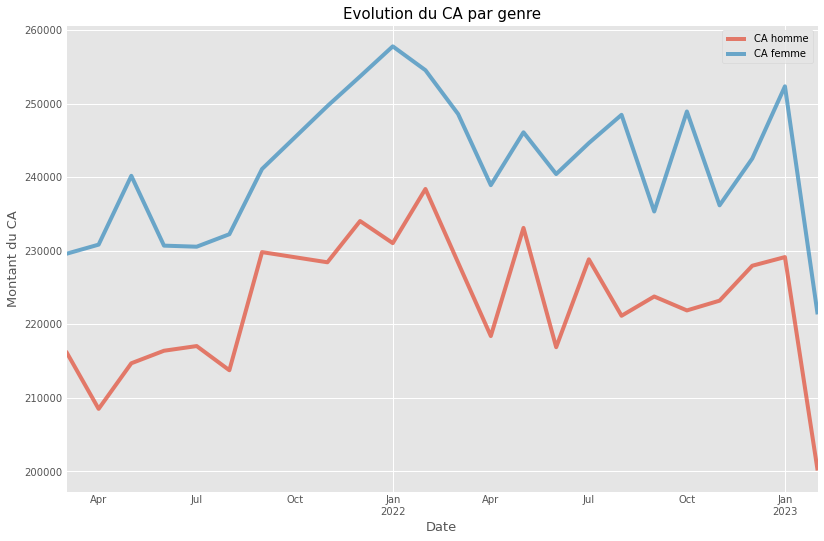

In [104]:
CA_homme['price'].plot(label = 'CA homme',alpha=0.7)
CA_femme['price'].plot(label = 'CA femme',alpha=0.7)
plt.style.use('ggplot')
plt.title('Evolution du CA par genre',fontsize=15)
plt.xlabel('Date',fontsize=13)
plt.ylabel('Montant du CA',fontsize=13)
plt.legend();

 Les comportements d'achat entre les hommes et les femmes est sembleble et suivent les mêmes tendances à quelques différences mineurs près.

### CA par catégorie d'âge

#### Répartition du CA par catégorie d'âge

<Figure size 1080x432 with 0 Axes>

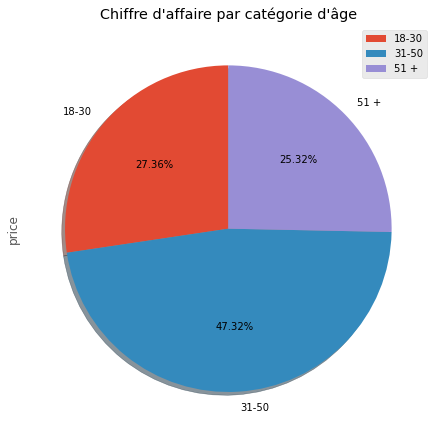

In [105]:
plt.figure(figsize=(15,6))
pd.pivot_table(data=BTC,index='classe_age',values='price',aggfunc='sum').plot(kind='pie',y='price',figsize=(20,7),legend=True,
               shadow=True,pctdistance=0.6,autopct='%1.2f%%',startangle =90)
plt.title("Chiffre d'affaire par catégorie d'âge");

#### Evolution du CA par catégorie d'âge

In [106]:
CA_cl1 = pd.pivot_table(BTC.loc[BTC['classe_age']=='18-30'],values='price',index="year_month", aggfunc='sum')
CA_cl2 = pd.pivot_table(BTC.loc[BTC['classe_age']=='31-50'],values='price',index="year_month", aggfunc='sum')
CA_cl3 = pd.pivot_table(BTC.loc[BTC['classe_age']=='51 +'],values='price',index="year_month", aggfunc='sum')

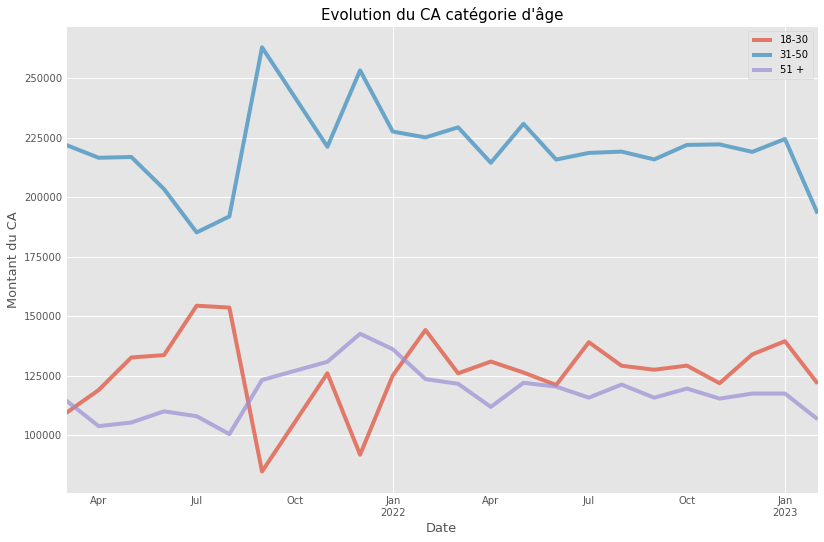

In [107]:
CA_cl1['price'].plot(label = '18-30',alpha=0.7)
CA_cl2['price'].plot(label = '31-50',alpha=0.7)
CA_cl3['price'].plot(label = '51 +',alpha=0.7)

plt.style.use('ggplot')
plt.title("Evolution du CA catégorie d'âge",fontsize=15)
plt.xlabel('Date',fontsize=13)
plt.ylabel('Montant du CA',fontsize=13)
plt.legend();

## Répartitions des ventes par produits (top/flop)

In [108]:
# Représentation graphique de la disstribution des produits par catégorie

In [109]:
distrib_cate = df_clean.groupby(['id_prod',"categ"])[['price']].count() 

In [110]:
# Le nombre de références par catégorie de produit
nb_refByCateg = pd.pivot_table(data=df_clean, index='categ', values='id_prod',
                               aggfunc=pd.Series.nunique).reset_index().rename(columns={'id_prod': 'nb_ref'})
nb_refByCateg

categ  nb_ref
0      0    2290
1      1     737
2      2     236

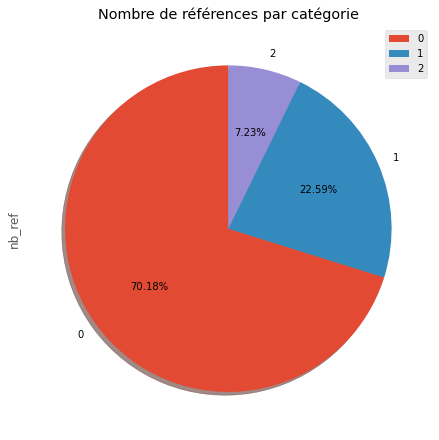

In [111]:
nb_refByCateg.plot(kind='pie',y='nb_ref',figsize=(20,7),legend=True,
               shadow=True,pctdistance=0.6,autopct='%1.2f%%',startangle =90)
plt.title("Nombre de références par catégorie");

<Figure size 864x576 with 0 Axes>

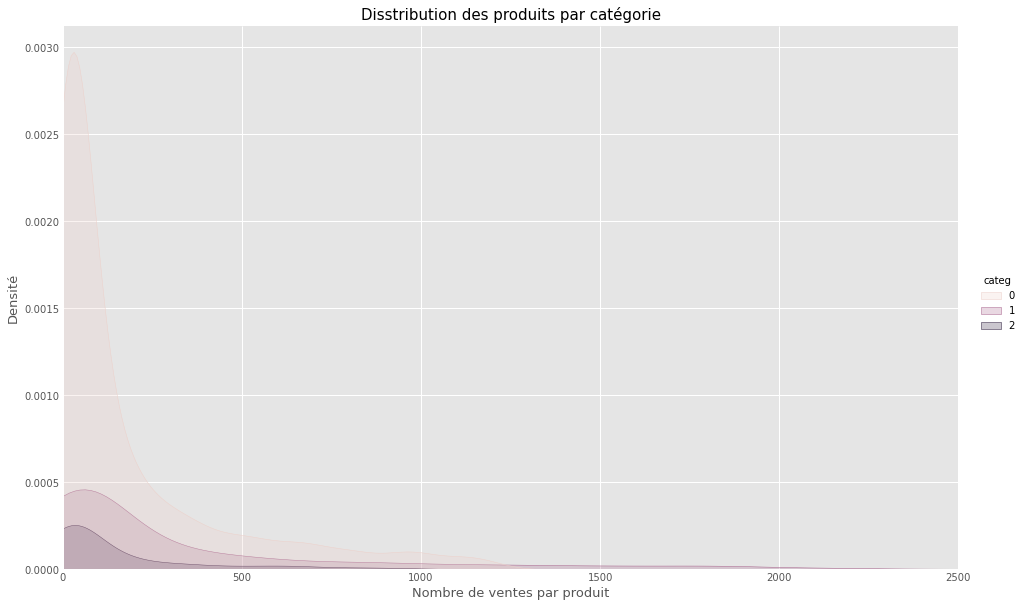

In [112]:
plt.figure()
sns.displot(distrib_cate, x="price", hue="categ", kind="kde", fill=True,height=8.27, aspect=8.7/5.27)
plt.title("Disstribution des produits par catégorie",fontsize=15)
plt.xlabel('Nombre de ventes par produit',fontsize=13)
plt.ylabel('Densité',fontsize=13)
plt.xlim([0,2500]) 
plt.show()

<Figure size 864x576 with 0 Axes>

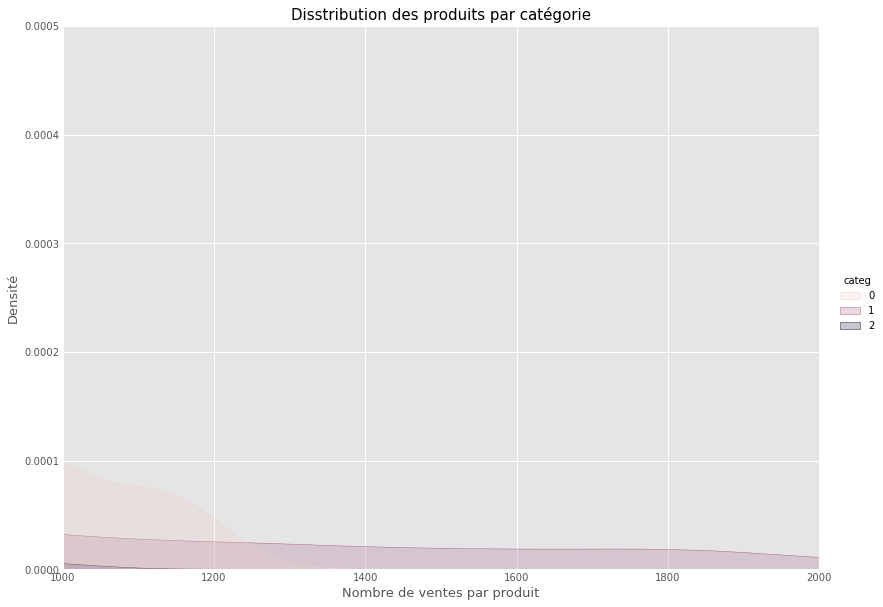

In [113]:
plt.figure()

sns.displot(distrib_cate, x="price", hue="categ", kind="kde", fill=True,height=8.27, aspect=11.7/8.27)

plt.title("Disstribution des produits par catégorie",fontsize=15)
plt.xlabel('Nombre de ventes par produit',fontsize=13)
plt.ylabel('Densité',fontsize=13)
plt.xlim([1000,2000]) 
plt.ylim([0,0.0005]) 
plt.show()

In [114]:
# ZOOM top/flop par catégorie avec id_prod

In [115]:
# On cherche à trouver les meilleurs et les pires ventes (nombre d'achat)/réference

In [116]:
distrib_cate2 = distrib_cate.groupby(['id_prod',"categ"])[['price']].count()
distrib_cate2 = distrib_cate.reset_index().rename(columns={'price': 'nb_ref'})

In [117]:
b_all = distrib_cate2.loc[(distrib_cate2['nb_ref'] >1000 ), :]
b_0 = distrib_cate2.loc[(distrib_cate2['categ'] == 0)&(distrib_cate2['nb_ref'] >1000 ), :]
b_1 = distrib_cate2.loc[(distrib_cate2['categ'] == 1)&(distrib_cate2['nb_ref'] >1000 ), :]
b_2 = distrib_cate2.loc[(distrib_cate2['categ'] == 2)&(distrib_cate2['nb_ref'] >1000 ), :]

In [118]:
print('On obtient donc : ',len(b_all), "de best seller à plus de 1000 produits vendus toute catégorie confondue")
print('')
print("Nombre de best-seller de catégorie 0 s'élève à: ", len(b_0))
print('')
print("Nombre de best-seller de catégorie 0 s'élève à: ", len(b_1))
print('')
print("Nombre de best-seller de catégorie 0 s'élève à: ", len(b_2))

On obtient donc :  124 de best seller à plus de 1000 produits vendus toute catégorie confondue

Nombre de best-seller de catégorie 0 s'élève à:  52

Nombre de best-seller de catégorie 0 s'élève à:  72

Nombre de best-seller de catégorie 0 s'élève à:  0


In [119]:
f_all = distrib_cate2.loc[(distrib_cate2['nb_ref'] <50 ), :]
f_0 = distrib_cate2.loc[(distrib_cate2['categ'] == 0)&(distrib_cate2['nb_ref'] <50 ), :]
f_1 = distrib_cate2.loc[(distrib_cate2['categ'] == 1)&(distrib_cate2['nb_ref'] <50 ), :]
f_2 = distrib_cate2.loc[(distrib_cate2['categ'] == 2)&(distrib_cate2['nb_ref'] <50 ), :]

In [120]:
print('On obtient donc : ',len(f_all), "de produits qui se sont vendus à moins de 50 exemplaires")
print('')
print("Nombre de flop de catégorie 0 s'élève à: ", len(f_0))
print('')
print("Nombre de flop de catégorie 0 s'élève à: ", len(f_1))
print('')
print("Nombre de flop de catégorie 0 s'élève à: ", len(f_2))

On obtient donc :  1580 de produits qui se sont vendus à moins de 50 exemplaires

Nombre de flop de catégorie 0 s'élève à:  1156

Nombre de flop de catégorie 0 s'élève à:  296

Nombre de flop de catégorie 0 s'élève à:  128


<Figure size 1080x432 with 0 Axes>

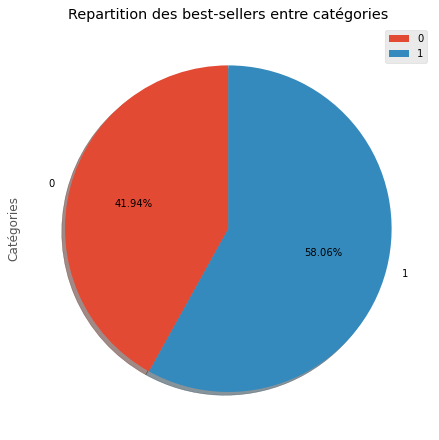

In [121]:
plt.figure(figsize=(15,6))
pd.pivot_table(data=b_all,index='categ',values='nb_ref',aggfunc='count').plot(kind='pie',y='nb_ref',figsize=(20,7),legend=True,
               shadow=True,pctdistance=0.6,autopct='%1.2f%%',startangle =90)
plt.ylabel("Catégories",fontsize=12)
plt.title("Repartition des best-sellers entre catégories");

<Figure size 1080x432 with 0 Axes>

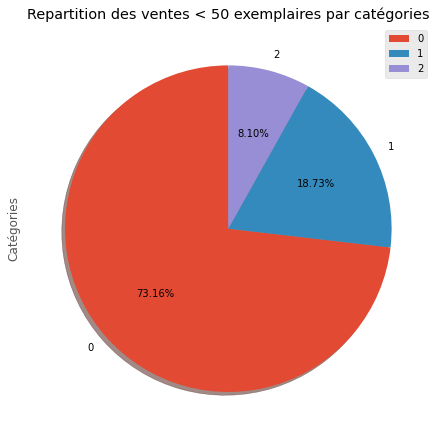

In [122]:
plt.figure(figsize=(15,6))
pd.pivot_table(data=f_all,index='categ',values='nb_ref',aggfunc='count').plot(kind='pie',y='nb_ref',figsize=(20,7),legend=True,
               shadow=True,pctdistance=0.6,autopct='%1.2f%%',startangle =90)
plt.ylabel("Catégories",fontsize=12)
plt.title("Repartition des ventes < 50 exemplaires par catégories");

# Analyse ciblée sur les client (Julie)

 En s'appuyant sur le théorème central limite nous pouvons utiliser des tests parametriques dans notre situation étant donnée que la taille de l'échantillon est trés grande.

## La taille du panier moyen et les catégories des livres achetés

Quand on dispose d’un petit échantillon, la pertinence de ce test repose sur la validation de plusieurs hypothèses :

1) l’indépendance entre les échantillons de chaque groupe

2) l’égalité des variances que l’on peut verifier avec un test de Bartlett.

3) la normalité des résidus avec un test de Shapiro.

1) L’indépendance 

 Elle est assurée dans notre échantillon. Chaque panier est indépendant des autres.

2) L’égalité des variances

On parle aussi d’homoscédasticité. C’est une des 3 conditions de validité d’une ANOVA. On cherche à démontrer que les variances de chaque groupe sont égales. Dans un boxplot, l’amplitude des boîtes traduit graphiquement l’égalité des variances.

In [123]:
panier_categ = BTC.groupby(["categ", "session_id"])[['price']].sum()
panier_categ = panier_categ.reset_index().rename(columns={'price': 'prix_total'})
panier_categ.sample()

categ session_id  prix_total
329424      1   s_340122       23.83

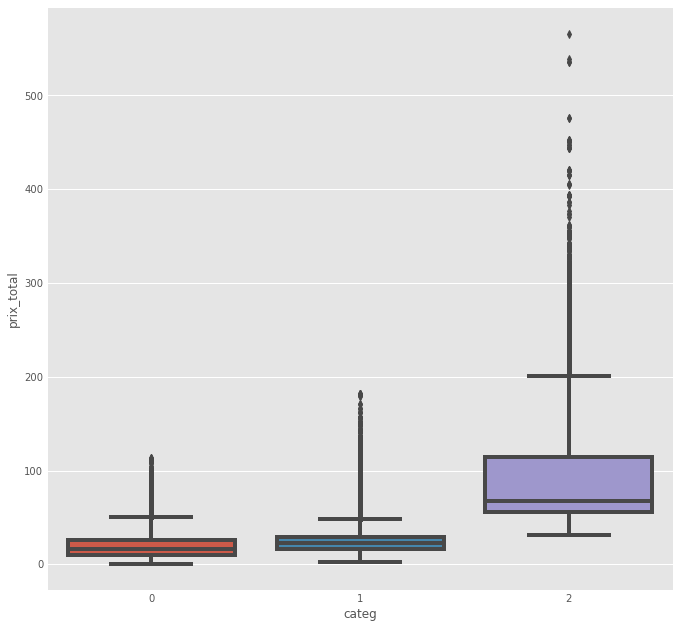

In [124]:
plt.subplots(figsize=(10,10))
ax = sns.boxplot(x="categ", y="prix_total",orient ='v', data=panier_categ)

In [125]:
 panier_categ.groupby("categ")['prix_total'].agg('var')

categ
0     180.687098
1     222.122667
2    3026.463865
Name: prix_total, dtype: float64

In [126]:
bartlett(panier_categ.prix_total[panier_categ.categ == 0],
        panier_categ.prix_total[panier_categ.categ == 1],
        panier_categ.prix_total[panier_categ.categ == 2])

BartlettResult(statistic=194409.46427263683, pvalue=0.0)

3) Normalité des résidus

In [127]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import shapiro
model = ols('prix_total ~ categ', data=panier_categ).fit()
shapiro(model.resid)

ShapiroResult(statistic=0.7295219898223877, pvalue=0.0)

p-value = 0.0 < 5% --> les résidus ne suivent donc pas une loi normale. Nous ne pouvons donc pas appliquer l'ANOVA dans notre cas.

A partir de là, les conditions de l'égalité des variances nécessaires pour un test ANOVA ne sont pas remplies. Nous devons nous orienter sur un test non-paramétrique équivalent. Dans le cas présent nous allons partir sur le test de Kruskal. C'est le test non paramétrique le mieux adapté quand nous avons plus de 2 variables qualitatives et une variable quantitative.

In [128]:
# test de Kruskal (test non paramétrique entre variable quanti et quali)

kstat, pval = stats.kruskal(*[group["prix_total"].values for name, group in panier_categ.groupby("categ")])

# Récupérer la p-value

print(pval) # Si pval petit (au moins inférieure à 0.05, alors on peut parler de différence significative)

0.0


Dans notre cas, la p-value est très basse, on peut donc supposer qu'au moins une des 3 catégories de livres diffère des autres pour la taille du panier moyen de manière significative. Ce qui confirme bien le boxplot obtenue plus haut (nottement la catégorie 2).

## Taille du panier moyen et catégorie d'âge

In [129]:
panier_age = BTC.groupby(["classe_age", "session_id"])[['price']].sum()
panier_age = panier_age.reset_index().rename(columns={'price': 'prix_total'})
panier_age.sample()

classe_age session_id  prix_total
104271      31-50   s_232623       34.51

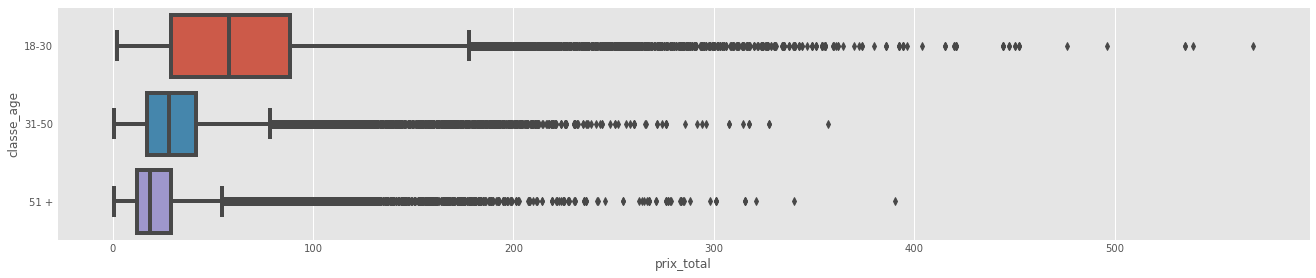

In [130]:
plt.subplots(figsize=(20,4))
ax = sns.boxplot(x="prix_total", y="classe_age", data=panier_age)

In [131]:
 panier_age.groupby("classe_age")['prix_total'].agg('var')

classe_age
18-30    3124.555034
31-50     490.358889
51 +      458.641516
Name: prix_total, dtype: float64

 Déjà à ce stade on peut voir graphiquement que les variances entre nos groupes sont vraiment différentes, ce qui est confirmé par les calculs des variances ci-dessus.

In [132]:
from scipy.stats import bartlett
bartlett(panier_age.prix_total[panier_age.classe_age == '18-30'],
        panier_age.prix_total[panier_age.classe_age == '31-50'],
        panier_age.prix_total[panier_age.classe_age == '51 +'])

BartlettResult(statistic=93651.27927801204, pvalue=0.0)

 A partir de là, les conditions de l'égalité des variances nécessaires pour un test ANOVA ne sont pas remplies. Nous devons nous orienter sur un test non-paramétrique équivalent. Dans le cas présent nous allons partir sur le test de Kruskal. 

In [133]:
panier_age.sample()

classe_age session_id  prix_total
48233      31-50   s_125309       27.99

In [134]:
# test de Kruskal (test non paramétrique entre variable quanti et quali)

kstat, pval = stats.kruskal(*[group["prix_total"].values for name, group in panier_age.groupby("classe_age")])

# Récupérer la p-value

print(pval) # Si pval petit (au moins inférieure à 0.05, alors on peut parler de différence significative)

0.0


Dans notre cas, la p-value est très basse, on peut donc supposer qu'au moins une des 3 classes d'âge diffère des autres pour la taille du panier moyen de manière significative. Ce qui confirme bien le boxplot obtenue plus haut.

## Le lien entre le genre d’un client et les catégories des livres achetés

In [135]:
# 1. On fait un tableau de contingence
cross_tab = pd.crosstab(BTC['sex'], BTC['categ'])
cross_tab

categ       0       1      2
sex                         
f      191919  110550  16429
m      177945  100227  15351

In [136]:
# 2. Calcul du Chi-2: ici la P-Value s'affiche en 2nde position (8.48e-05)
stats.chi2_contingency(cross_tab, correction = True)

(18.749695983469746,
 8.48311292992366e-05,
 2,
 array([[192594.45687199, 109755.15820979,  16548.38491822],
        [177269.54312801, 101021.84179021,  15231.61508178]]))

In [137]:
# p-value  (8,48 *10^-5) < alpha (0.05) 

# Nous pouvons donc rejeté l'hypothèse 0. Le genre de notre client affecte le choix de catégorie de livres qu'il achete.

In [138]:
X = "sex"
Y = "categ"

cont1 = BTC[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont1

categ       0       1      2   Total
sex                                 
f      191919  110550  16429  318898
m      177945  100227  15351  293523
Total  369864  210777  31780  612421

In [139]:
pourcent_sex_categ = cont1.div(cont1.Total, axis = 0)
pourcent_sex_categ

categ         0         1         2  Total
sex                                       
f      0.601819  0.346663  0.051518    1.0
m      0.606239  0.341462  0.052299    1.0
Total  0.603937  0.344170  0.051892    1.0

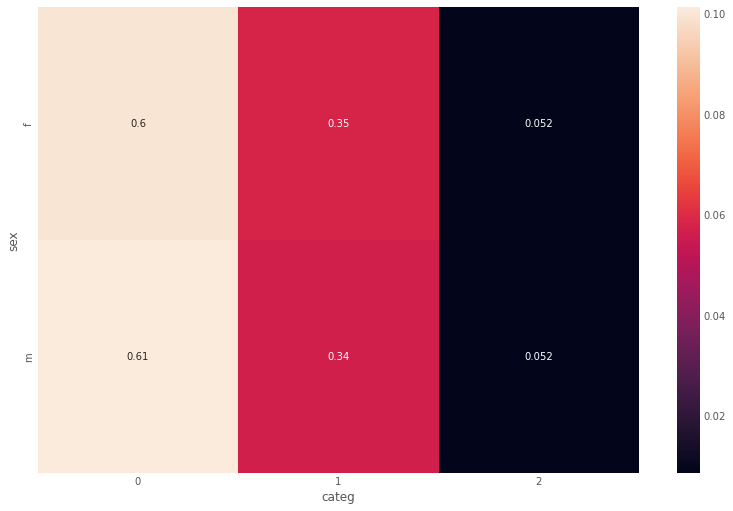

In [140]:
tx = pourcent_sex_categ.loc[:,["Total"]]
ty = pourcent_sex_categ.loc[["Total"],:]
n = len(BTC)
indep = tx.dot(ty) / n
c = pourcent_sex_categ.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.show()

 Ici les hommes et les femmes achètent majoritérement des produits de catégorie 0, puis celle de la catégorie 1 et enfin des livres de catégorie 2.
 
  Au vue de la taille de notre échantillon (plus de 600 000) une différence même de 0.1% entre les deux groupes peut être significative. 
  
 Dans notre cas les femmes sont légerement plus susceptibles d'acheter des produits de catégorie 1 par rapport aux hommes (35% contre 34%), les hommes à leur tours s'intéresse d'avantage aux produits de catégorie 0 par rapport aux femmes(61% contrre 60%). En ce qui concerne les produits de catégorie 2, les hommes sont légerement majoritaires sur ces produits.

## Le lien entre l’âge des clients et le montant total des achats

In [141]:
BTC.head()

id_prod                       date session_id client_id  price  categ sex  \
0  0_1518 2022-05-20 13:21:29.043970   s_211425     c_103   4.18      0   f   
1  0_1518 2021-07-20 13:21:29.043970    s_64849     c_103   4.18      0   f   
2  0_1518 2022-08-20 13:21:29.043970   s_255965     c_103   4.18      0   f   
3  0_1418 2022-06-18 01:49:37.823274   s_225411     c_103   8.57      0   f   
4  0_1418 2021-08-18 01:49:37.823274    s_77214     c_103   8.57      0   f   

   birth year_month  age classe_age  
0   1986    2022-05   36      31-50  
1   1986    2021-07   36      31-50  
2   1986    2022-08   36      31-50  
3   1986    2022-06   36      31-50  
4   1986    2021-08   36      31-50

In [142]:
panier = pd.pivot_table(data=BTC, index='age', values='price',
                               aggfunc="sum").reset_index()

In [143]:
pearsonr(panier['price'], panier['age'])

(-0.8310651217614257, 1.5465125092308723e-20)

Text(0, 0.5, 'CA')

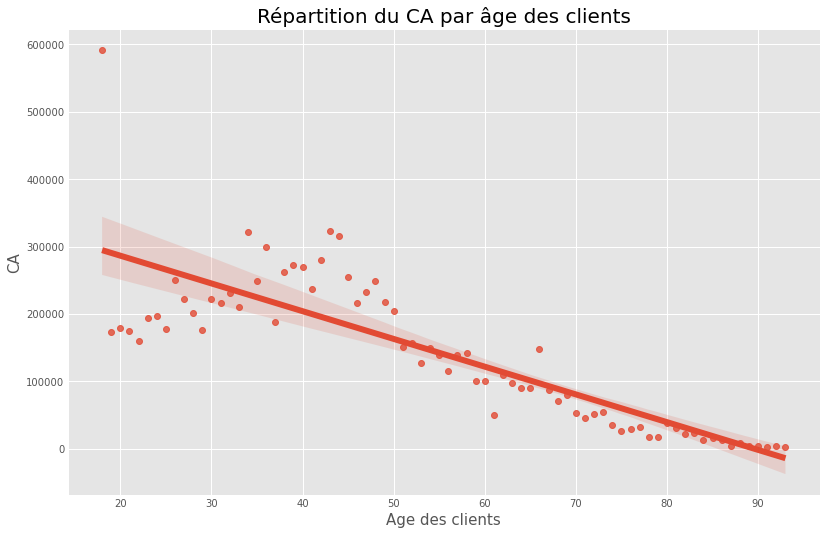

In [144]:
sns.regplot(x='age', y='price', data =panier)
plt.title("Répartition du CA par âge des clients",fontsize=20)
plt.xlabel("Age des clients",fontsize=15)                                                                                 
plt.ylabel("CA",fontsize=15)

 p-val(=1.55e-20) < alpha (0.05) --> rejet de H0 --> Ha --> il existe une correlation entre l'âge et le montant total des achats. 

 On obtien ici une corrélation négative assez forte qui s'éloigne de 0 pour atteindre -0.83 qui nous indique qu'il existe une relation forte et négative entre l'âge et le montant total des achats. Cela veut dire qu'avec l'âge le montant total des achats a tendance à baisser.

## Age et  la fréquence d’achat

In [145]:
btcf = BTC.copy()
btcf

id_prod                       date session_id client_id   price  categ  \
0       0_1518 2022-05-20 13:21:29.043970   s_211425     c_103    4.18      0   
1       0_1518 2021-07-20 13:21:29.043970    s_64849     c_103    4.18      0   
2       0_1518 2022-08-20 13:21:29.043970   s_255965     c_103    4.18      0   
3       0_1418 2022-06-18 01:49:37.823274   s_225411     c_103    8.57      0   
4       0_1418 2021-08-18 01:49:37.823274    s_77214     c_103    8.57      0   
...        ...                        ...        ...       ...     ...    ...   
679106   2_147 2021-07-23 07:01:38.963669    s_65994    c_4391  181.99      2   
679107   0_142 2022-03-25 18:07:25.880052   s_184472    c_1232   19.85      0   
679108   0_142 2021-09-25 18:07:25.880052    s_95415    c_1232   19.85      0   
679109   2_205 2021-03-11 00:11:32.016264     s_4605    c_7534  100.99      2   
679110   2_205 2022-07-11 00:11:32.016264   s_236636    c_7534  100.99      2   

       sex  birth year_month  age classe_age  
0        f   1986    2022-05   36      31-50  
1        f   1986    2021-07   36      31-50  
2        f   1986    2022-08   36      31-50  
3        f   1986    2022-06   36      31-50  
4        f   1986    2021-08   36      31-50  
...     ..    ...        ...  ...        ...  
679106   f   2001    2021-07   21      18-30  
679107   f   1960    2022-03   62       51 +  
679108   f   1960    2021-09   62       51 +  
679109   m   1992    2021-03   30      18-30  
679110   m   1992    2022-07   30      18-30  

[612421 rows x 11 columns]

 Nous allons dans ce cas utiliser le test de Spearman car le coefficient de Pearson ne détecte les corrélations que lorsque notre distribution est linéaire. Ce qui n'est pas le cas dans notre situation.

In [146]:
age_freq = btcf.groupby(['client_id',"age","classe_age"])[['price']].count().rename(columns={'price': 'nb_ref'}) 
age_freq = age_freq.reset_index().rename(columns={'price': 'nb_ref'})

In [147]:
st.spearmanr(age_freq['age'], age_freq["nb_ref"])

SpearmanrResult(correlation=0.12958115437347437, pvalue=1.6805702128967786e-33)

Text(0, 0.5, "Nombre d'achat par client")

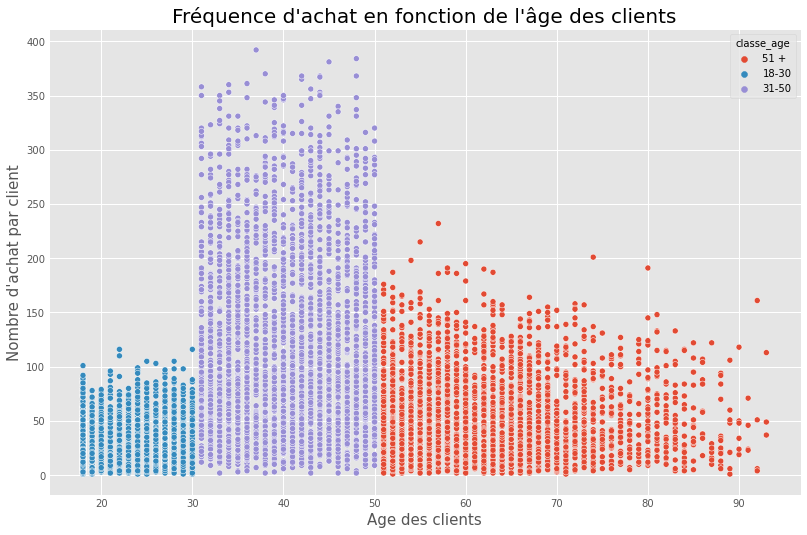

In [148]:
sns.scatterplot(x='age', y="nb_ref", hue = 'classe_age', data =age_freq)
plt.title("Fréquence d'achat en fonction de l'âge des clients",fontsize=20)
plt.xlabel("Age des clients",fontsize=15)                                                                          
plt.ylabel("Nombre d'achat par client",fontsize=15)

 p-val (1.6e-33) < alpha (0.05) --> rejet de H0 --> Ha --> une correlation entre la fréquence d'achat et l'âge

 On observe ici trés clairement qu'il existe 3 groupes avec des fréquences d'achats vraiment differents les uns des autres. Nous allons voir ces comportement plus en détails en regroupant nos données dans le graphique suivant.

In [149]:
#1. On cherche le nombre de client uniques
BTC_freq = BTC.copy()
BTC_freq.drop_duplicates(subset=['client_id'], inplace=True, ignore_index=True)
# 2. Le nombre de client unique par âge
nb_client_age = pd.pivot_table(data=BTC_freq, index='age', values='price',
                               aggfunc="count").reset_index()
nb_client_age.rename(columns = {'price': "nombre de client"}, inplace = True)
# 3. le nombre d'achat par âge
nb_achat_age = pd.pivot_table(data=BTC, index='age', values='price',
                               aggfunc="count").reset_index()
nb_achat_age.rename(columns = {'price': "nombre d'achat"}, inplace = True)
nb_achat_age['achats mensuels'] = round(nb_achat_age["nombre d'achat"]/23,2)
# 4. Calcul de la fréquence d'âchat mensuelle par âge
freq_achat_age = pd.merge(nb_client_age,nb_achat_age, on = 'age', how = 'inner')
freq_achat_age["fréquence d'achat par mois"] = freq_achat_age["achats mensuels"]/freq_achat_age["nombre de client"]

Text(0, 0.5, 'Fréquence moyenne mensuelle')

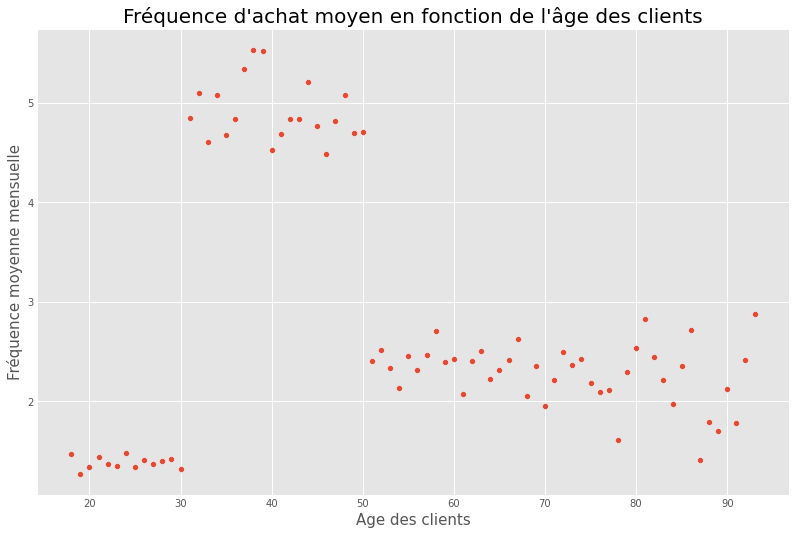

In [150]:
sns.scatterplot(x='age', y="fréquence d'achat par mois", data =freq_achat_age)

#On rajoute la légende
plt.title("Fréquence d'achat moyen en fonction de l'âge des clients",fontsize=20)

plt.xlabel("Age des clients",fontsize=15)                              
                                                
plt.ylabel("Fréquence moyenne mensuelle",fontsize=15)

Nous pouvons ainsi conclure que l'âge du client influence sa fréquence d'achat. On distingue 3 groupes au comportements différents:

Nos clients âgées entre 18-30 ans ont des fréquences d'achat les plus faibles (autour de 1.5 livre/mois).

Puis les clients entre 31-50 ans sont ceux qui achetent le plus fréquement des livres chez nous (autour de 5 livres/mois)

Enfin passé les 51 ans, les fréquences d'achat baissent à nouveau et restent stables (autour de 2.2 livre/mois)

In [151]:
#Panier moyen par groupe d'âge

panier_age_moyenne = panier_age.groupby(["classe_age"])[['prix_total']].mean()
panier_age_moyenne = panier_age_moyenne.reset_index().rename(columns={'price': 'prix du panier moyen'})
panier_age_moyenne

classe_age  prix_total
0      18-30   70.989215
1      31-50   32.152367
2       51 +   24.530578

Text(10.05, 0.5, 'Montant du panier moyen')

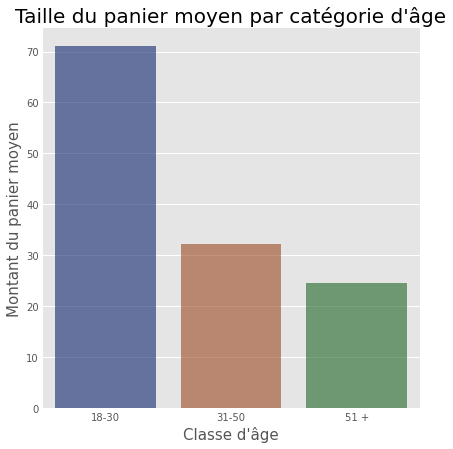

In [152]:
sns.catplot(data=panier_age_moyenne, kind="bar",x="classe_age", y="prix_total", palette="dark", alpha=.6, height=6)
plt.title("Taille du panier moyen par catégorie d'âge",fontsize=20)
plt.xlabel("Classe d'âge",fontsize=15) 
plt.ylabel("Montant du panier moyen",fontsize=15)

Text(0, 0.5, 'Catégorie')

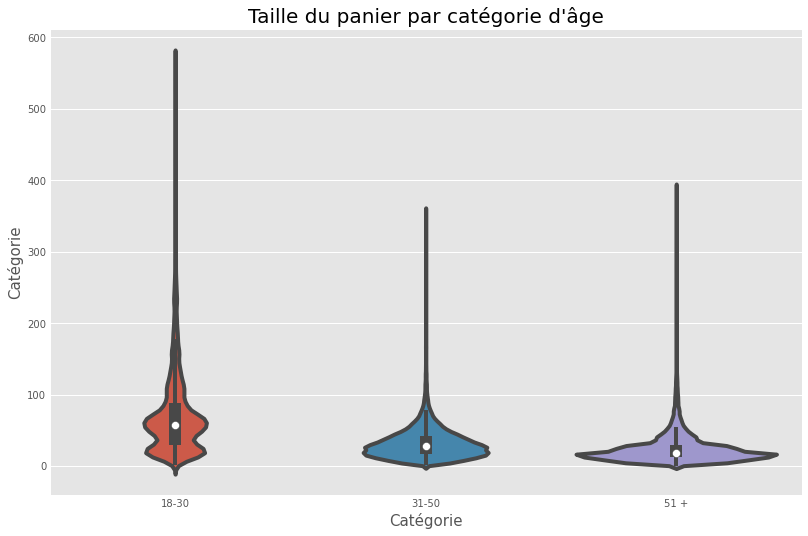

In [153]:
sns.violinplot(data=panier_age, x="classe_age", y="prix_total")
plt.title("Taille du panier par catégorie d'âge",fontsize=20)
plt.xlabel("Catégorie",fontsize=15) 
plt.ylabel("Catégorie",fontsize=15)

## Classe d'âge et catégorie

In [154]:
# 1. On fait un tableau de contingence
cross_tab2 = pd.crosstab(BTC['classe_age'], BTC['categ'])
cross_tab2
# 2. Calcul du Chi-2: ici la P-Value s'affiche en 2nde position (0.0)
stats.chi2_contingency(cross_tab2, correction = True)

(265011.4399579216,
 0.0,
 4,
 array([[ 43909.87896235,  25023.23166906,   3772.88936859],
        [229078.92442617, 130546.81843536,  19683.25713847],
        [ 96875.19661148,  55206.94989558,   8323.85349294]]))

 p-value  (0.0) < alpha (0.05) 

 Nous pouvons donc rejeté l'hypothèse 0. La classe d'âge de notre client affecte le choix de catégorie de livres qu'il achete.

In [155]:
X = "classe_age"
Y = "categ"

cont3 = BTC[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont3

categ            0       1      2   Total
classe_age                               
18-30        15915   27879  28912   72706
31-50       285746   92133   1430  379309
51 +         68203   90765   1438  160406
Total       369864  210777  31780  612421

In [156]:
pourcent_age_categ = cont3.div(cont3.Total.Total, axis = 0)
pourcent_age_categ

categ              0         1         2     Total
classe_age                                        
18-30       0.025987  0.045523  0.047209  0.118719
31-50       0.466584  0.150441  0.002335  0.619360
51 +        0.111366  0.148207  0.002348  0.261921
Total       0.603937  0.344170  0.051892  1.000000

In [157]:
tx = pourcent_age_categ.loc[:,["Total"]]
ty = pourcent_age_categ.loc[["Total"],:]
n = len(BTC)
indep = tx.dot(ty) / n
c = pourcent_age_categ.fillna(0)
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n

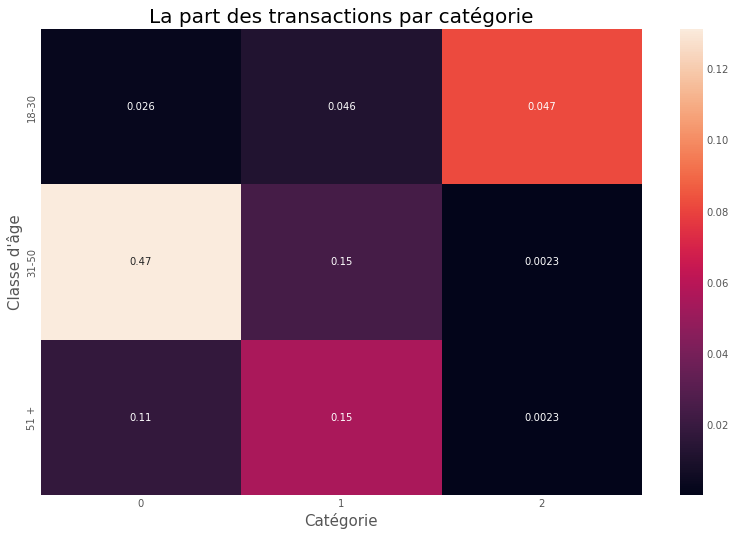

In [158]:
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.title("La part des transactions par catégorie",fontsize=20)
plt.xlabel("Catégorie",fontsize=15)                              
plt.ylabel("Classe d'âge",fontsize=15)
plt.show()

On voit trés clairement que des clients de chaque classe d'âge préviligie les catégories différentes.
 
 Les 18-30 ans ont tendance à préféré les produits de catégorie 2, puis 1 et enfin 0.
 
 Les 31-50 ans achètent trés majoritairement sur des produits de catégorie 0, suivie de 1, puis 3.
 
 Les clients de plus de 51 ans favorise la catégorie 1, puis 0 et enfin la 2.

## Le nombre de sessions par catégorie d'âge

In [159]:
panier_age.groupby(["classe_age"])[['prix_total']].count()

prix_total
classe_age            
18-30            41139
31-50           157127
51 +            110211

<Figure size 1080x432 with 0 Axes>

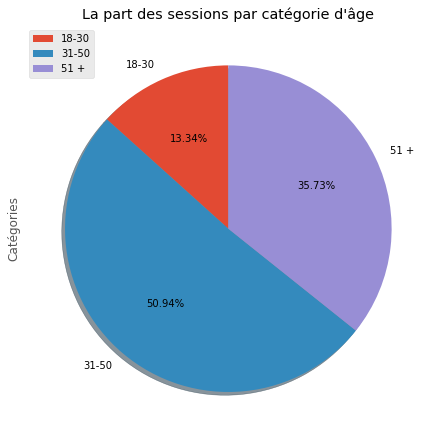

In [160]:
plt.figure(figsize=(15,6))


pd.pivot_table(data=panier_age,
               index='classe_age',
               values='prix_total',
               aggfunc='count').plot(kind='pie',
                                   y='prix_total',
                                   figsize=(20,7),
                                   legend=True,
                                   shadow=True,
                                   pctdistance=0.6,
                                   autopct='%1.2f%%',
                                   startangle =90)

plt.ylabel("Catégories",fontsize=12)

plt.title("La part des sessions par catégorie d'âge");

 En terme de nombre de session les 18-30 ans sont très en dessous des autres catégories avec seulement 13%, suivie de 51 ans et plus avec 36% et 31-50 ans sont ceux qui ont le plus de sessions d'enregistré sur notre plateforme.

# Conclusion

In [162]:
classae_a = ['18-30', '31-50','51 +']
CA = [27.36, 47.32,25.32]
nb_trans = [11.87,61.94,26.19]
amplitude = [13,20,44]
freq = [0.8,5,2.3]
categorie = ['cat 2: 39.67%/ cat 1: 38.00%/ cat 0: 21.89%','cat 0: 75.33%/ cat 1: 24.29%/ cat 2: 0.38%','cat 1: 56.59%/ cat 0: 42.52%/ cat 2: 0.89%']
panier = [70.99,13.15,24.53]

dicti = {"classe d'âge": classae_a,
         'Amplitude de la classe': amplitude,
         'CA (%)': CA,
         'Part des transactions(%)': nb_trans,
         "Fréquence d'achat mensuel": freq,
         'Catégorie de livres achetées': categorie,
          "Panier moyen(€)":panier}

df_conclusion = pd.DataFrame(dicti)

 D'après toutes les relations que nous avons analysé, la variable d'âge apparaît comme la plus importante en ce qui concerne la catégorisation de nos clients. Il serait donc intéressant de découper nos clients par classe d'âge afin d'obtenir des groupes homogènes et cibler ces différents groupes de manière différente.
 
 Ainsi on peut obtenir nos 3 catégories de client aux comportement disticts:

In [163]:
df_conclusion

classe d'âge  Amplitude de la classe  CA (%)  Part des transactions(%)  \
0        18-30                      13   27.36                     11.87   
1        31-50                      20   47.32                     61.94   
2         51 +                      44   25.32                     26.19   

   Fréquence d'achat mensuel                 Catégorie de livres achetées  \
0                        0.8  cat 2: 39.67%/ cat 1: 38.00%/ cat 0: 21.89%   
1                        5.0   cat 0: 75.33%/ cat 1: 24.29%/ cat 2: 0.38%   
2                        2.3   cat 1: 56.59%/ cat 0: 42.52%/ cat 2: 0.89%   

   Panier moyen(€)  
0            70.99  
1            13.15  
2            24.53

  Les 18-30 ans achètent nos produits plus rarement que les autres groupes, cependant l'essentiel de leurs achats se trouve dans les produits de catégorie 2 et 1, donc nos produits les plus chers. C'est la tranche d'âge qui a de loin le panier moyen le plus élevé.
 Il serait intéressant de stimiuler la fréquence d'achat de ces client(abonnement avec réduction pour les -31 ans par exemple).
 
 Les 31-50 ans est le groupe le plus important. Il le plus de CA, achète fréquement des livres et se focalise essentiellement sur des produits de catégorie 0 (les moins chers). 
 Pour exploiter d'avantage ce groupe, nous pouvons les orienter vers des livres de catégorie 1 et 2 qui augmentera leur panier payen. La fréquence d'achat étant déjà élevée, la marge de progression sur cet axe devient plus compliquée.
 
 Les 51 + est notre catégorie d'âge avec la plus grande amplitude d'âge. Elle a des fréquences d'achat et la taille du panier moyen qui se situe entre les 2 groupes précédentes. Nous pouvons donc stimuler ce groupe par rapport à la fréquence d'achat ainsi que par leur orientation vers les produits de catégorie 2.

In [164]:
 # EXEMPLE AVEC ANOVA COURS

In [165]:
X = "categ" # qualitative
Y = "price" # quantitative

sous_echantillon = BTC

In [166]:
#calcul de 𝜂2:
X = "categ" # qualitative
Y = "price" # quantitative

def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
print ("𝜂2 =", round(eta_squared(sous_echantillon[X],sous_echantillon[Y]),2)," cela sigifie que la différence entre les 3 catégories sur le critère de prix est trés elevée.")

#calcul de la p-value:
fvalue, pvalue = stats.f_oneway(BTC[BTC['categ']==0].price, BTC[BTC['categ']==1].price, BTC[BTC['categ']==2].price)
print('')
print("La p-value = ",pvalue, "< alpha = 0.05")
print('')
print("Nous pouvons donc écarter notre H0 et affirmer qu'il existe une corrélation entre a taille du panier moyen et les catégories des livres achetés")

𝜂2 = 0.64  cela sigifie que la différence entre les 3 catégories sur le critère de prix est trés elevée.

La p-value =  0.0 < alpha = 0.05

Nous pouvons donc écarter notre H0 et affirmer qu'il existe une corrélation entre a taille du panier moyen et les catégories des livres achetés


In [167]:
modalites = sous_echantillon[X].unique()
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

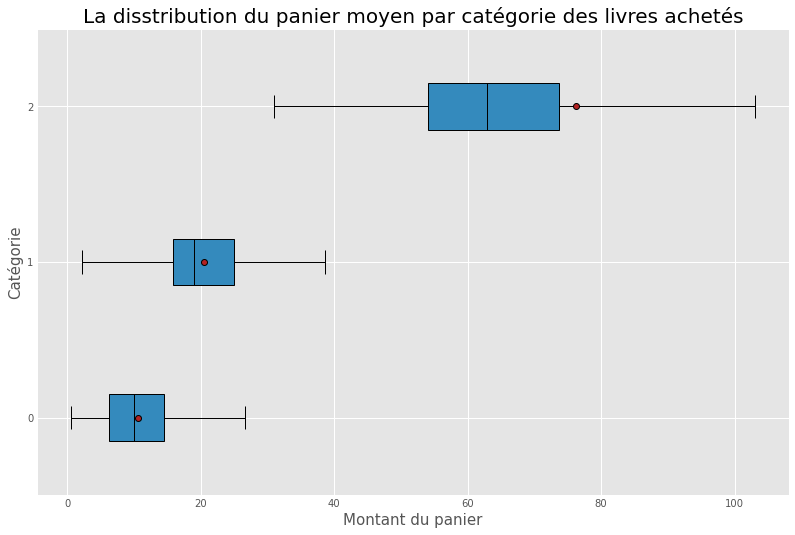

In [168]:
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title("La disstribution du panier moyen par catégorie des livres achetés",fontsize=20)
plt.xlabel("Montant du panier",fontsize=15)                                                                                 
plt.ylabel("Catégorie",fontsize=15)
plt.show()

Les points rouges au milieu de chaque boîte à moustaches représentent la moyenne des valeurs.

On voit ici que les montants sont très différents d'une catégorie à l'autre. Ici on constate que plus la catégorie est élevé et plus le montant dépensé par nos client est dispersé et plus il est élevé. Nous allons vérifier cette affirmation par les chiffres, grâce à une modélisation.

 Pour cela nous allons calculer le 𝜂2  (eta carré). 

 Toutes nos analyses convergent bien dans le même sens et nous pouvons affirmer qu'il existe une relation entre la taille du panier moyen et les catégories des livres achetés.

In [169]:
# EX COURS ANOVA n2: 

In [170]:
#calcul de 𝜂2:
X = "classe_age" # qualitative
Y = "price" # quantitative
sous_echantillon = BTC
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
print ("𝜂2 =", round(eta_squared(sous_echantillon[X],sous_echantillon[Y]),2)," cela sigifie que la différence entre les 3 catégories sur le critère de prix est trés elevée.")
fvalue, pvalue = stats.f_oneway(BTC[BTC['classe_age']=='18-30'].price, BTC[BTC['classe_age']=='31-50'].price, BTC[BTC['classe_age']=='51 +'].price)
print("La p-value = ",pvalue, "< alpha = 0.05")
print('')
print("Nous pouvons donc écarter notre H0 et affirmer qu'il existe une corrélation entre a taille du panier moyen et la classe d'âge du client")

𝜂2 = 0.22  cela sigifie que la différence entre les 3 catégories sur le critère de prix est trés elevée.
La p-value =  0.0 < alpha = 0.05

Nous pouvons donc écarter notre H0 et affirmer qu'il existe une corrélation entre a taille du panier moyen et la classe d'âge du client
